# Submission_8 from <a href="http://petroanalytix.com/">PetroAnalytix Team</a>

* PE Imputer generated by TPOT
* Classifier using XGB

In [1]:
import numpy as np
np.random.seed(0)

import warnings
warnings.filterwarnings("ignore")

import time as tm

import pandas as pd

import xgboost as xgb

from tpot import TPOTRegressor, TPOTClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn.multiclass import OneVsOneClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.signal import medfilt

%matplotlib inline

/home/taufan/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Modified imputation method using TPOT

In [2]:
pe_fv = pd.read_csv('../facies_vectors.csv')
pe_nf = pd.read_csv('../nofacies_data.csv')

In [3]:
Xfv = pe_fv[pe_fv["PE"].notnull()].drop(['Formation', 'Well Name', 'Depth', 'Facies', 'PE'], axis=1).values
Xnf = pe_nf[pe_nf["PE"].notnull()].drop(['Formation', 'Well Name', 'Depth', 'PE'], axis=1).values
Xpe = np.concatenate((Xfv, Xnf))

Yfv = pe_fv[pe_fv["PE"].notnull()]["PE"].values
Ynf = pe_nf[pe_nf["PE"].notnull()]["PE"].values
Ype = np.concatenate((Yfv, Ynf))

In [4]:
Xpetr, Xpete, Ypetr, Ypete = train_test_split(Xpe, Ype, train_size=0.7, test_size=0.3, random_state=7)

In [5]:
from sklearn.decomposition import FastICA
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer

pe_imputer = make_pipeline(
    make_union(
        FastICA(tol=0.96),
        FunctionTransformer(lambda X: X)
    ),
    ExtraTreesRegressor(max_features=0.64, n_estimators=500, n_jobs=4, random_state=7)
)

pe_imputer.fit(Xpe, Ype)

Pipeline(steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('fastica', FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=None, random_state=None, tol=0.96, w_init=None,
    whiten=True)), ('functiontransformer', FunctionTransformer(accept_sparse=..._estimators=500, n_jobs=4,
          oob_score=False, random_state=7, verbose=0, warm_start=False))])

## Load dataset

In [6]:
training_data = pd.read_csv("../facies_vectors.csv")

In [7]:
XimpPE = training_data[training_data["PE"].isnull()].drop(['Formation', 'Well Name', 'Depth', 'Facies', 'PE'], axis=1).values

In [8]:
training_data["PE"][training_data["PE"].isnull()] = pe_imputer.predict(XimpPE)

### Utilities function

In [9]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

adjacent_facies = np.array([[1], [0, 2], [1], [4], [3, 5], [4, 6, 7], [5, 7], [5, 6, 8], [6, 7]])


def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

def mad_based_outlier(points, thresh=4.5):
    median = np.median(points, axis=0)
    diff = (points - median)**2
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation
    
    return abs(modified_z_score),abs(modified_z_score) > thresh


In [10]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

In [11]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '.g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '.')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '.', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '.', color='r')
    ax[4].plot(logs.PE, logs.Depth, '.', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

## Extract data

In [12]:
X = training_data.drop(['Formation', 'Well Name', 'Depth', 'Facies', 'FaciesLabels'], axis=1).values
y = training_data['Facies'].values - 1

wells = training_data["Well Name"].values

### Feature Augmentation method from Bestagini

In [13]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug

In [14]:
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad

In [15]:
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

In [16]:
well = training_data['Well Name'].values
depth = training_data['Depth'].values

In [17]:
X, padded_rows = augment_features(X, well, depth, N_neig=1)

In [18]:
scaler = preprocessing.RobustScaler().fit(X)
X = scaler.transform(X)

## Validation with Leave One Well Out on Training Dataset

In [19]:
logo = LeaveOneGroupOut()

t0 = tm.time()

In [20]:
f1s_ls = []
acc_ls = []
adj_ls = []


for train, test in logo.split(X, y, groups=wells):
    well_name = wells[test[0]]
    
    X_tr = X[train]
    X_te = X[test]

    Y_tr = y[train]

    # XGBoost
    exported_pipeline = OneVsOneClassifier(xgb.XGBClassifier(n_estimators=200, max_depth=3,
                                                             gamma=0.5, reg_alpha=0.5,
                                                             learning_rate=0.05,
                                                             min_child_weight=1,
                                                             subsample=0.9,
                                                             colsample_bytree=0.9,
                                                             seed=7, nthread =4),
                                           n_jobs=4)
    
    exported_pipeline.fit(X_tr, Y_tr)
    
    # Predict
    y_hat = exported_pipeline.predict(X_te)
    y_hat = medfilt(y_hat, kernel_size=5)
    
    try:
        f1s = f1_score(y[test], y_hat, average="weighted", labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
    except:
        f1s = 0

    try:
        conf = confusion_matrix(y[test], y_hat, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
        acc = f1_score(y[test], y_hat, average="micro", labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
    except:
        acc = 0

    try:
        acc_adj = accuracy_adjacent(conf, adjacent_facies)
    except:
        acc_adj = 0

    f1s_ls += [f1s]
    acc_ls += [acc]
    adj_ls += [acc_adj]
    print("{:>20s} f1w:{:.3f} | f1m:{:.3f} | acc_adj:{:.3f}".format(well_name, f1s, acc, acc_adj))

t1 = tm.time()
print("Avg F1w", np.average(f1s_ls)*100, "Avg F1m", np.average(acc_ls)*100, "Avg Adj", np.average(adj_ls)*100)
print((t1-t0), "seconds")

         ALEXANDER D f1w:0.585 | f1m:0.612 | acc_adj:0.878
     CHURCHMAN BIBLE f1w:0.589 | f1m:0.606 | acc_adj:0.881
      CROSS H CATTLE f1w:0.443 | f1m:0.451 | acc_adj:0.880
            KIMZEY A f1w:0.557 | f1m:0.576 | acc_adj:0.893
            LUKE G U f1w:0.652 | f1m:0.631 | acc_adj:0.948
               NEWBY f1w:0.553 | f1m:0.585 | acc_adj:0.909
               NOLAN f1w:0.541 | f1m:0.528 | acc_adj:0.884
          Recruit F9 f1w:0.904 | f1m:0.825 | acc_adj:1.000
             SHANKLE f1w:0.600 | f1m:0.597 | acc_adj:0.984
           SHRIMPLIN f1w:0.591 | f1m:0.622 | acc_adj:0.932
Avg F1w 60.1607491214 Avg F1m 60.3365432593 Avg Adj 91.9008165621
38.7889244556427 seconds


## Applying to Test Dataset

In [21]:
blind_data = pd.read_csv('../nofacies_data.csv')

X_blind = blind_data.drop(['Formation', 'Well Name', 'Depth'], axis=1).values
well_blind = blind_data['Well Name'].values
depth_blind = blind_data['Depth'].values
X = np.delete(X, padded_rows, axis=0)
y = np.delete(y, padded_rows, axis=0) 

X_blind, padded_rows = augment_features(X_blind, well_blind, depth_blind, N_neig=1)

In [22]:
# Scaling
X_train = X
X_blind = scaler.transform(X_blind)

in_dim = len(X_train[0])

In [23]:
model = OneVsOneClassifier(xgb.XGBClassifier(n_estimators=200, max_depth=3,
                                                             gamma=0.5, reg_alpha=0.5,
                                                             learning_rate=0.05,
                                                             min_child_weight=1,
                                                             subsample=0.9,
                                                             colsample_bytree=0.9,
                                                             seed=7, nthread =4),
                                           n_jobs=4)

model.fit(X_train, y)

# Predict
y_blind = model.predict(X_blind)
y_blind = medfilt(y_blind, kernel_size=5)

blind_data["Facies"] = y_blind + 1  # return the original value (1-9)

In [24]:
blind_data.to_csv("PA_Team_Submission_8_XGB.csv")

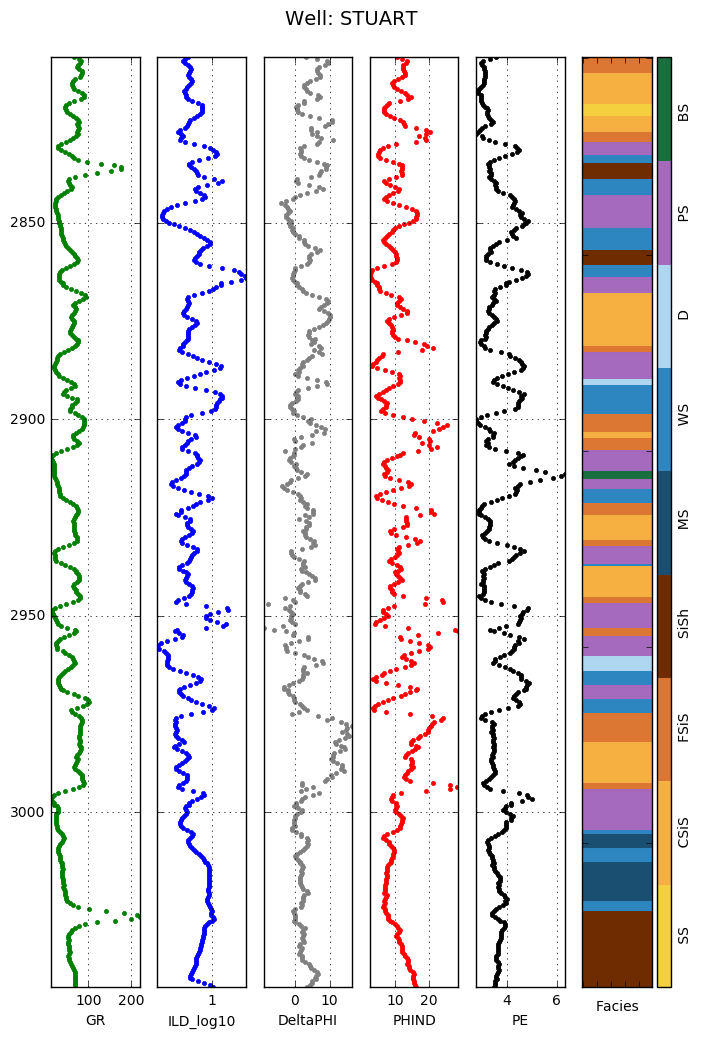

In [25]:
make_facies_log_plot(
    blind_data[blind_data['Well Name'] == 'STUART'],
    facies_colors)

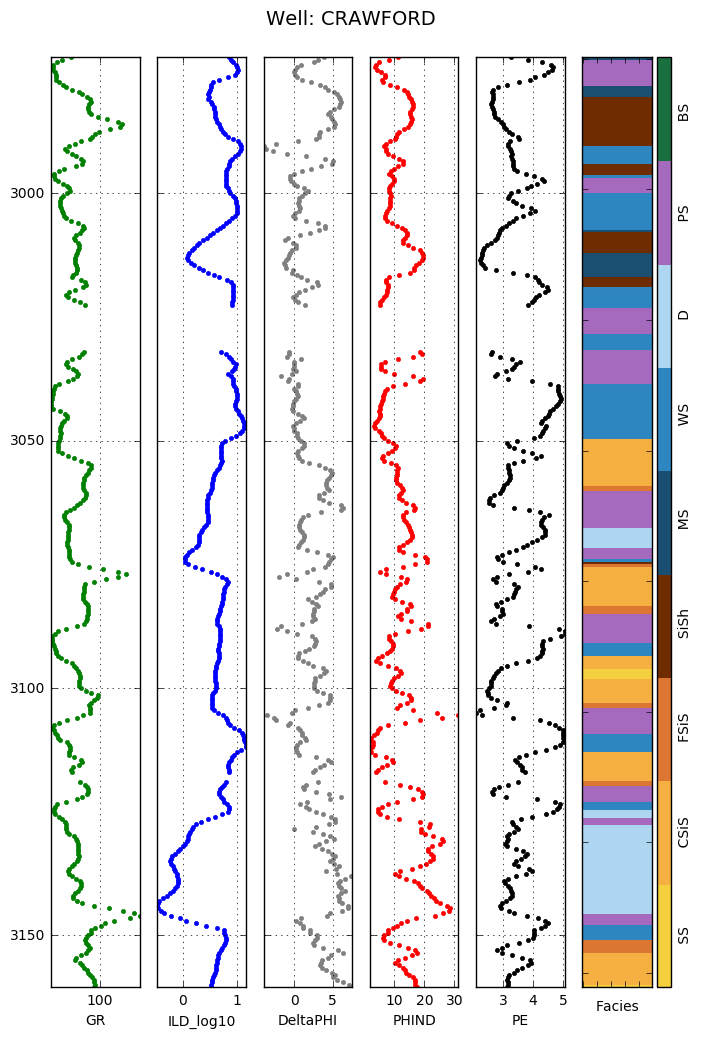

In [26]:
make_facies_log_plot(
    blind_data[blind_data['Well Name'] == 'CRAWFORD'],
    facies_colors)